In [ ]:
import numpy as np
import pandas as pd
from math import sqrt

from matplotlib import pyplot
from pandas import read_csv

from pandas import DataFrame
from pandas import concat

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
!pip install hydroeval
!pip install SGD


from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pywt
np.random.seed(2020)
from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, LSTM, Bidirectional, BatchNormalization
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from keras.layers.core import Dense, Activation
from keras.regularizers import l1_l2, l2
from numpy import array
import warnings

import matplotlib.pyplot as plt
from keras import optimizers

from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go

In [ ]:
df = pd.read_csv(r'D:\iitkgp\saa\final.csv')
df.head()

,Date,basantpur_rainfall,Andhiyarkhore,Bamnidhi,Simga,Ghatora,Rajim,Rampur,Basantpur
0,01-07-2001,21.944357,5.400,1350.000,35.00,150.000,160.000,108.000,2250.000
1,02-07-2001,3.318059,4.078,496.334,97.25,78.000,150.366,119.859,1353.260
2,03-07-2001,2.335704,3.071,163.761,105.40,35.327,62.633,68.933,1145.230
3,04-07-2001,7.705987,2.343,156.041,67.31,21.230,36.257,48.694,676.221
4,05-07-2001,31.771525,2.321,148.249,48.46,22.491,29.935,23.432,646.760


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                1012 non-null   object 
 1   basantpur_rainfall  1012 non-null   float64
 2   Andhiyarkhore       1012 non-null   float64
 3   Bamnidhi            1012 non-null   float64
 4   Simga               1012 non-null   float64
 5   Ghatora             1012 non-null   float64
 6   Rajim               1012 non-null   float64
 7   Rampur              1012 non-null   float64
 8   Basantpur           1012 non-null   float64
dtypes: float64(8), object(1)
memory usage: 71.3+ KB


In [ ]:
cols=list(df)[1:9]
data=df[cols].astype(float)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data= scaler.fit_transform(data)

In [ ]:
#converts col into different array
R,Qa,Qbi,Qs,Qg,Qr,Qrm,Qb =scaled_data.T

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  #n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var(t-%d)' % (i))] #for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var(t)')] #for j in range(n_vars)]
    else:
      names += [('var(t+%d)' % (i))] #for j in range(n_vars)]
# put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
# drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [ ]:
#Is = series_to_supervised(I,4,2)
Rs = series_to_supervised(R,3,1)
Qas = series_to_supervised(Qa,3,1)
Qbis= series_to_supervised(Qbi,3,1)
Qss = series_to_supervised(Qs,3,1)
Qgs = series_to_supervised(Qg,3,1)
Qrs = series_to_supervised(Qr,3,1)
Qrms = series_to_supervised(Qrm,3,1)
Qbs = series_to_supervised(Qb,3,2)
#Rs = series_to_supervised(R,1,1)

In [ ]:
dfs=[Rs,Qas,Qbis,Qss,Qgs,Qrs,Qrms,Qbs]
Input=pd.concat(dfs,axis=1,keys=range(1,len(dfs)+1))
Input.columns = Input.columns.map('{0[1]}{0[0]}'.format)
Input = Input.iloc[3-0:] #change iloc only if u cange lag days
Input = Input.drop(Input.index[-1:])

In [ ]:
Input.columns

Index(['var(t-3)1', 'var(t-2)1', 'var(t-1)1', 'var(t)1', 'var(t-3)2',
       'var(t-2)2', 'var(t-1)2', 'var(t)2', 'var(t-3)3', 'var(t-2)3',
       'var(t-1)3', 'var(t)3', 'var(t-3)4', 'var(t-2)4', 'var(t-1)4',
       'var(t)4', 'var(t-3)5', 'var(t-2)5', 'var(t-1)5', 'var(t)5',
       'var(t-3)6', 'var(t-2)6', 'var(t-1)6', 'var(t)6', 'var(t-3)7',
       'var(t-2)7', 'var(t-1)7', 'var(t)7', 'var(t-3)8', 'var(t-2)8',
       'var(t-1)8', 'var(t)8', 'var(t+1)8'],
      dtype='object')

In [ ]:
Input

,var(t-3)1,var(t-2)1,var(t-1)1,var(t)1,var(t-3)2,var(t-2)2,var(t-1)2,var(t)2,var(t-3)3,var(t-2)3,...,var(t)6,var(t-3)7,var(t-2)7,var(t-1)7,var(t)7,var(t-3)8,var(t-2)8,var(t-1)8,var(t)8,var(t+1)8
6,0.081014,0.334020,0.308209,0.182478,0.003978,0.003941,0.006606,0.020403,0.018960,0.017951,...,0.124113,0.004401,0.002095,0.002460,0.007934,0.020320,0.019429,0.021313,0.031854,0.039174
7,0.334020,0.308209,0.182478,0.241542,0.003941,0.006606,0.020403,0.011954,0.017951,0.021439,...,0.100364,0.002095,0.002460,0.007934,0.031897,0.019429,0.021313,0.031854,0.039174,0.129853
8,0.308209,0.182478,0.241542,0.409743,0.006606,0.020403,0.011954,0.048305,0.021439,0.052034,...,0.844190,0.002460,0.007934,0.031897,0.126150,0.021313,0.031854,0.039174,0.129853,0.473977
9,0.182478,0.241542,0.409743,0.187636,0.020403,0.011954,0.048305,0.069608,0.052034,0.031128,...,0.414098,0.007934,0.031897,0.126150,0.067826,0.031854,0.039174,0.129853,0.473977,0.302142
10,0.241542,0.409743,0.187636,0.253682,0.011954,0.048305,0.069608,0.039898,0.031128,0.032914,...,0.141782,0.031897,0.126150,0.067826,0.025491,0.039174,0.129853,0.473977,0.302142,0.144966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0.026240,0.048115,0.145416,0.049192,0.053647,0.026902,0.021112,0.018255,0.031069,0.036486,...,0.017562,0.024851,0.015539,0.020225,0.013163,0.107042,0.022709,0.070436,0.060635,0.055443
1007,0.048115,0.145416,0.049192,0.007834,0.026902,0.021112,0.018255,0.018253,0.036486,0.052095,...,0.017530,0.015539,0.020225,0.013163,0.013151,0.022709,0.070436,0.060635,0.055443,0.048120
1008,0.145416,0.049192,0.007834,0.000533,0.021112,0.018255,0.018253,0.014383,0.052095,0.050553,...,0.019187,0.020225,0.013163,0.013151,0.012462,0.070436,0.060635,0.055443,0.048120,0.028554
1009,0.049192,0.007834,0.000533,0.000100,0.018255,0.018253,0.014383,0.013407,0.050553,0.043512,...,0.017202,0.013163,0.013151,0.012462,0.008213,0.060635,0.055443,0.048120,0.028554,0.023694


In [ ]:
y=Input[Input.columns[Input.columns.isin(['var(t+1)8'])]]

In [ ]:
y

,var(t+1)8
6,0.039174
7,0.129853
8,0.473977
9,0.302142
10,0.144966
...,...
1006,0.055443
1007,0.048120
1008,0.028554
1009,0.023694


In [ ]:
x=Input.drop(['var(t+1)8'],axis=1)

In [ ]:
x

,var(t-3)1,var(t-2)1,var(t-1)1,var(t)1,var(t-3)2,var(t-2)2,var(t-1)2,var(t)2,var(t-3)3,var(t-2)3,...,var(t-1)6,var(t)6,var(t-3)7,var(t-2)7,var(t-1)7,var(t)7,var(t-3)8,var(t-2)8,var(t-1)8,var(t)8
6,0.081014,0.334020,0.308209,0.182478,0.003978,0.003941,0.006606,0.020403,0.018960,0.017951,...,0.011465,0.124113,0.004401,0.002095,0.002460,0.007934,0.020320,0.019429,0.021313,0.031854
7,0.334020,0.308209,0.182478,0.241542,0.003941,0.006606,0.020403,0.011954,0.017951,0.021439,...,0.124113,0.100364,0.002095,0.002460,0.007934,0.031897,0.019429,0.021313,0.031854,0.039174
8,0.308209,0.182478,0.241542,0.409743,0.006606,0.020403,0.011954,0.048305,0.021439,0.052034,...,0.100364,0.844190,0.002460,0.007934,0.031897,0.126150,0.021313,0.031854,0.039174,0.129853
9,0.182478,0.241542,0.409743,0.187636,0.020403,0.011954,0.048305,0.069608,0.052034,0.031128,...,0.844190,0.414098,0.007934,0.031897,0.126150,0.067826,0.031854,0.039174,0.129853,0.473977
10,0.241542,0.409743,0.187636,0.253682,0.011954,0.048305,0.069608,0.039898,0.031128,0.032914,...,0.414098,0.141782,0.031897,0.126150,0.067826,0.025491,0.039174,0.129853,0.473977,0.302142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0.026240,0.048115,0.145416,0.049192,0.053647,0.026902,0.021112,0.018255,0.031069,0.036486,...,0.027269,0.017562,0.024851,0.015539,0.020225,0.013163,0.107042,0.022709,0.070436,0.060635
1007,0.048115,0.145416,0.049192,0.007834,0.026902,0.021112,0.018255,0.018253,0.036486,0.052095,...,0.017562,0.017530,0.015539,0.020225,0.013163,0.013151,0.022709,0.070436,0.060635,0.055443
1008,0.145416,0.049192,0.007834,0.000533,0.021112,0.018255,0.018253,0.014383,0.052095,0.050553,...,0.017530,0.019187,0.020225,0.013163,0.013151,0.012462,0.070436,0.060635,0.055443,0.048120
1009,0.049192,0.007834,0.000533,0.000100,0.018255,0.018253,0.014383,0.013407,0.050553,0.043512,...,0.019187,0.017202,0.013163,0.013151,0.012462,0.008213,0.060635,0.055443,0.048120,0.028554


In [ ]:
x_train=x[:639]
# x_val=x[501:701]
x_test=x[639:]
y_train=y[:639]
# y_val=y[501:701]
y_test=y[639:]

In [ ]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape
# x_val.shape,y_val.shape

((639, 32), (366, 32), (639, 1), (366, 1))

In [ ]:
#converting dataframe to array to reshape in next step
x_train=x_train.values
y_train=y_train.values
x_test=x_test.values
y_test=y_test.values
# x_val=x_val.values
# y_val=y_val.values

In [ ]:
# #reshape into 3-D cz model cannot perform in 2-D
# x_train = x_train.reshape((x_train.shape[0],1,x_train.shape[1]))
# # x_val = x_val.reshape((x_val.shape[0],1,x_val.shape[1]))
# x_test = x_test.reshape((x_test.shape[0],1,x_test.shape[1]))

In [ ]:
x_train.shape

(639, 32)

In [ ]:
from keras.layers import Dense, Flatten, Dropout, MaxPooling1D, TimeDistributed, LSTM, BatchNormalization, Input, concatenate, Conv1D

In [ ]:
import keras
import tensorflow as tf
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config)
keras.backend.set_session(sess)

In [ ]:
# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units=64, activation = 'relu', input_dim = x_train.shape[1]))
model.add(Dense(units = 64, activation = 'relu'))
# model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
# model.add(Dropout(0.25))
# model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
# model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid'))
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

# nn_model = Sequential()
# nn_model.add(Dense(50, input_dim=x_train.shape[1], activation='relu'))
# nn_model.add(Dense(units = 50, activation = 'relu'))
# nn_model.add(Dense(1,activation = 'sigmoid'))
# nn_model.compile(loss='mean_squared_error', optimizer='adam')
# early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
# # history = nn_model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the ANN
history = model.fit(x_train, y_train, batch_size=128, epochs =200, validation_split=0.2)

Epoch 1/200
4/4 [==============================] - 9s 202ms/step - loss: 0.1903 - val_loss: 0.1689
Epoch 2/200
4/4 [==============================] - 0s 15ms/step - loss: 0.1764 - val_loss: 0.1565
Epoch 3/200
4/4 [==============================] - 0s 15ms/step - loss: 0.1629 - val_loss: 0.1436
Epoch 4/200
4/4 [==============================] - 0s 13ms/step - loss: 0.1490 - val_loss: 0.1293
Epoch 5/200
4/4 [==============================] - 0s 14ms/step - loss: 0.1336 - val_loss: 0.1133
Epoch 6/200
4/4 [==============================] - 0s 14ms/step - loss: 0.1173 - val_loss: 0.0955
Epoch 7/200
4/4 [==============================] - 0s 15ms/step - loss: 0.1000 - val_loss: 0.0769
Epoch 8/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0831 - val_loss: 0.0589
Epoch 9/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0674 - val_loss: 0.0433
Epoch 10/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0533 - val_loss: 0.0309
Epoch 11/200
4/4 [

Epoch 84/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0107 - val_loss: 0.0072
Epoch 85/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0103 - val_loss: 0.0065
Epoch 86/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0098 - val_loss: 0.0056
Epoch 87/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0091 - val_loss: 0.0045
Epoch 88/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0078 - val_loss: 0.0034
Epoch 89/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0063 - val_loss: 0.0029
Epoch 90/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 91/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 92/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 93/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 94/2

4/4 [==============================] - 0s 13ms/step - loss: 2.5240e-04 - val_loss: 0.0020
Epoch 164/200
4/4 [==============================] - 0s 13ms/step - loss: 2.4821e-04 - val_loss: 0.0020
Epoch 165/200
4/4 [==============================] - 0s 14ms/step - loss: 2.4659e-04 - val_loss: 0.0020
Epoch 166/200
4/4 [==============================] - 0s 13ms/step - loss: 2.4607e-04 - val_loss: 0.0020
Epoch 167/200
4/4 [==============================] - 0s 15ms/step - loss: 2.4462e-04 - val_loss: 0.0020
Epoch 168/200
4/4 [==============================] - 0s 13ms/step - loss: 2.4189e-04 - val_loss: 0.0020
Epoch 169/200
4/4 [==============================] - 0s 13ms/step - loss: 2.4117e-04 - val_loss: 0.0020
Epoch 170/200
4/4 [==============================] - 0s 14ms/step - loss: 2.3865e-04 - val_loss: 0.0020
Epoch 171/200
4/4 [==============================] - 0s 13ms/step - loss: 2.3734e-04 - val_loss: 0.0020
Epoch 172/200
4/4 [==============================] - 0s 14ms/step - loss: 2.35

In [ ]:

hist_df = pd.DataFrame(history.history)
hist_df

,loss,val_loss
0,0.190300,0.168895
1,0.176371,0.156504
2,0.162942,0.143620
3,0.149033,0.129342
4,0.133643,0.113292
...,...,...
195,0.000210,0.002039
196,0.000211,0.002048
197,0.000210,0.002042
198,0.000208,0.002039


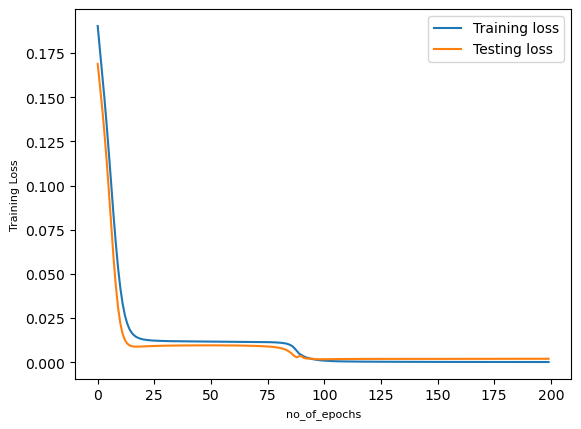

In [ ]:
plt.plot(history.history['loss'],label='Training loss' )
plt.plot(history.history['val_loss'], label='Testing loss')
plt.xlabel('no_of_epochs', fontsize=8 )
plt.ylabel('Training Loss', fontsize=8 )
plt.legend()

In [ ]:
train_yp = model.predict(x_train.reshape(len(x_train), x_train.shape[1]))
# val_yp = model.predict(x_val.reshape(len(x_val),1, x_val.shape[2], 1))
test_yp = model.predict(x_test.reshape(len(x_test), x_test.shape[1]))
# train_yp = model.predict(x_train)
# val_yp = model.predict(x_val)
# test_yp = model.predict(x_test)

12/12 [==============================] - 0s 5ms/step


In [ ]:

train_yp.shape

(639, 1)

In [ ]:
# val_yp.shape

In [ ]:
test_yp.shape

(366, 1)

In [ ]:
x_train.shape

(639, 32)

In [ ]:
#reshape into the origional form (2-D)
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1]))
# x_val= x_val.reshape((x_val.shape[0],x_val.shape[1]))
x_test= x_test.reshape((x_test.shape[0],x_test.shape[1]))

In [ ]:
#inverse_transform
#1)x_train
inv_x_train=pd.concat([pd.DataFrame(train_yp),pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_x_train)
y_train_prediction=rev_trans[:,0]

#y_train
inv_y_train=pd.concat([pd.DataFrame(y_train), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_y_train)
y_train_Observed=rev_trans[:,0]

#x_val
# inv_x_val=pd.concat([pd.DataFrame(val_yp), pd.DataFrame(x_train[:, :6])], axis=1)
# rev_trans=scaler.inverse_transform(inv_x_val)
# y_val_prediction=rev_trans[:,0]

# #y_val
# inv_y_val=pd.concat([pd.DataFrame(y_val), pd.DataFrame(x_train[:, :6])], axis=1)
# rev_trans=scaler.inverse_transform(inv_y_val)
# y_val_Observed=rev_trans[:,0]

#x_test
inv_x_test=pd.concat([pd.DataFrame(test_yp), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_x_test)
y_test_prediction=rev_trans[:,0]

#y_test
inv_y_test=pd.concat([pd.DataFrame(y_test), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_y_test)
y_test_Observed=rev_trans[:,0]

In [ ]:
y_train_pre=np.array(y_train_prediction)
y_train_rev=np.array(y_train_Observed)
l=np.array([y_train_prediction,y_train_Observed])
dataset=pd.DataFrame(l)
dataset=dataset.transpose()
dataset.columns = ['y_train_prediction', 'y_train_Observed']

In [ ]:
dataset

,y_train_prediction,y_train_Observed
0,5.489182,3.726210
1,7.687738,12.351425
2,44.426806,45.084113
3,28.147964,28.739332
4,13.717290,13.788960
...,...,...
634,6.145560,11.197687
635,6.673409,9.138130
636,5.669709,7.176296
637,5.468364,2.260289


<AxesSubplot:>

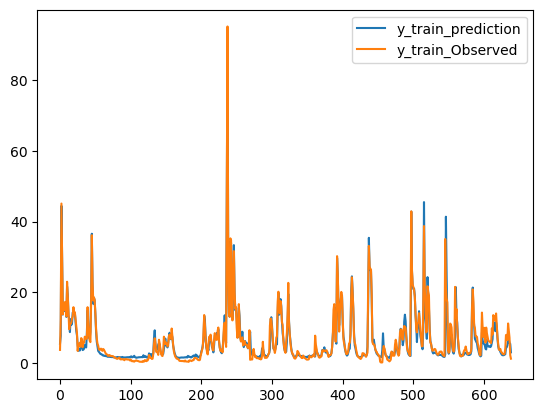

In [ ]:
dataset[['y_train_prediction','y_train_Observed']].plot()

In [ ]:
from hydroeval import evaluator, nse

NSE_train = evaluator(nse,y_train_prediction , y_train_Observed )
print(NSE_train)

[0.91631085]


In [ ]:
# y_val_pre=np.array(y_val_prediction)
# y_val_Observed=np.array(y_val_Observed)
# l=np.array([y_val_prediction,y_val_Observed])
# dataset_val=pd.DataFrame(l)
# dataset_val=dataset_val.transpose()
# dataset_val.columns = ['y_val_pre', 'y_val_Observed']
# dataset_val[['y_val_pre','y_val_Observed']].plot()

In [ ]:
# NSE_val = evaluator(nse,y_val_pre , y_val_Observed )
# print(NSE_val)

In [ ]:
y_train.shape

(639, 1)

In [ ]:
x_train.shape

(639, 32)

In [ ]:
x_test.shape

(366, 32)

In [ ]:
y_test.shape

(366, 1)

<AxesSubplot:>

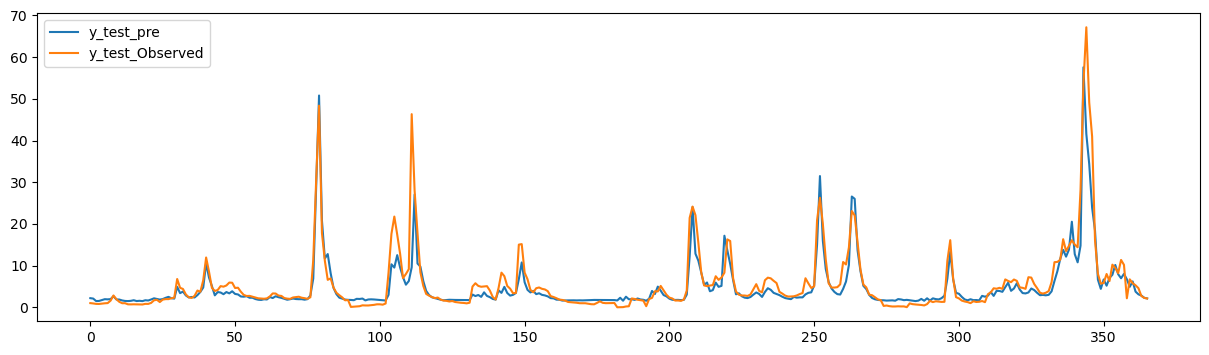

In [ ]:
#test
y_test_pre=np.array(y_test_prediction)
y_test_Observed=np.array(y_test_Observed)
l=np.array([y_test_prediction,y_test_Observed])
dataset_test=pd.DataFrame(l)
dataset_test=dataset_test.transpose()
dataset_test.columns = ['y_test_pre', 'y_test_Observed']
plt.rcParams["figure.figsize"] = (15,4)
dataset_test[['y_test_pre','y_test_Observed']].plot()



In [ ]:
dataset_test

,y_test_pre,y_test_Observed
0,2.187352,0.998535
1,2.087421,0.920371
2,1.493251,0.810365
3,1.519405,0.793638
4,1.738839,0.878219
...,...,...
634,NaN,NaN
635,NaN,NaN
636,NaN,NaN
637,NaN,NaN


C:\Users\RAJAN\AppData\Local\Temp\ipykernel_1272\47633976.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_lim, y_lim, 'k-', color = 'black', label = '1:1 line')


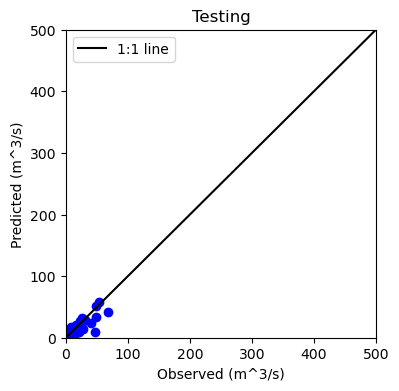

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4), dpi=100)
plt.scatter(y_test_Observed,y_test_pre, color='b')
y_lim = plt.ylim([0, 500])
x_lim = plt.ylim([0, 500])
plt.plot(x_lim, y_lim, 'k-', color = 'black', label = '1:1 line')
plt.ylim(y_lim)
plt.xlim(x_lim)
plt.title('Testing')
plt.xlabel("Observed (m^3/s)")
plt.ylabel("Predicted (m^3/s)")
plt.legend()

In [ ]:
#to save as csv file
# dataset_test.to_csv('/content/drive/MyDrive/Results_MTP/1day_test_Observed_prediction_ann.csv')

In [ ]:
NSE_test = evaluator(nse,y_test_pre , y_test_Observed )
print(NSE_test)

[0.81259675]


In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
np.random.seed(2020)
from hydroeval import evaluator,nse,kge,kgeprime,rmse,mare,pbias

RMSE_Training =evaluator(rmse,y_train_prediction , y_train_Observed)

RMSE_Testing = evaluator(rmse,y_test_pre , y_test_Observed)


MARE_Training =evaluator(mare,y_train_pre,y_train_Observed)

MARE_Testing = evaluator(mare,y_test_pre , y_test_Observed)


PBIAS_Training =evaluator(pbias,y_train_pre ,y_train_Observed)

PBIAS_Testing = evaluator(pbias,y_test_pre , y_test_Observed)

In [ ]:
RMSE_Training, RMSE_Testing, MARE_Training, MARE_Testing, PBIAS_Training, PBIAS_Testing

(array([2.27904308]),
 array([3.42428175]),
 array([0.17221095]),
 array([0.29383406]),
 array([3.43772217]),
 array([13.54887069]))

In [ ]:
#grid search

In [ ]:
batch_size = [256]
epochs = [200]
optimizer_ = ['adam','sgd','rmsprop','adgrad','adadelta','adamax','nadam','tfoptimizer']
loss_ = ['mean_squared_error','mean_absolute_error','mean_absolute_percentage_error','mean_squared_logarithmic_error','cosine_similarity','huber_loss','log_cosh']
activation_ = ['sigmoid','relu','softmax','softplus','softsign','tanh','selu','elu','exponential']
units_ = [100]
param_grid = dict(units=units_,batch_size=batch_size,epochs=epochs,activation = activation_,optimizer = optimizer_,loss = loss_)
param_grid

{'units': [100],
 'batch_size': [256],
 'epochs': [200],
 'activation': ['sigmoid',
  'relu',
  'softmax',
  'softplus',
  'softsign',
  'tanh',
  'selu',
  'elu',
  'exponential'],
 'optimizer': ['adam',
  'sgd',
  'rmsprop',
  'adgrad',
  'adadelta',
  'adamax',
  'nadam',
  'tfoptimizer'],
 'loss': ['mean_squared_error',
  'mean_absolute_error',
  'mean_absolute_percentage_error',
  'mean_squared_logarithmic_error',
  'cosine_similarity',
  'huber_loss',
  'log_cosh']}

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

In [ ]:
def LSTM_Model(activation = 'sigmoid',loss = 'mse',optimizer = 'adam',units = 50):
    model = Sequential()
    model.add(Dense(units = units, activation = activation, input_dim = x_train.shape[1]))
    model.add(Dense(units = units , activation = activation))
    model.add(Dense(units = 1, activation = activation))
    model.compile(optimizer = optimizer , loss = loss,metrics = [tf.keras.metrics.MeanSquaredError()])
    return model



model = KerasRegressor(build_fn=LSTM_Model, verbose=1)

grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring = "r2")

grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_activation', 'param_batch_size', 'param_epochs', 'param_loss', 'param_optimizer', 'param_units', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [ ]:
#getting keys from cv_results

grid.cv_results_.keys()

# storing all the results in dataframe

df = pd.DataFrame(grid.cv_results_)
df = df[['mean_fit_time', 'param_activation', 'param_batch_size', 'param_epochs', 'param_loss', 'param_optimizer', 'param_units', 'mean_test_score', 'rank_test_score']]

df.sort_values(by='rank_test_score', inplace=True)
df

,mean_fit_time,param_activation,param_batch_size,param_epochs,param_loss,param_optimizer,param_units,mean_test_score,rank_test_score
293,3.915969,tanh,256,200,mean_absolute_error,adamax,100,0.828516,1
421,3.832176,elu,256,200,mean_squared_logarithmic_error,adamax,100,0.822648,2
406,5.760442,elu,256,200,mean_absolute_error,nadam,100,0.821739,3
405,3.482533,elu,256,200,mean_absolute_error,adamax,100,0.819386,4
288,3.402534,tanh,256,200,mean_absolute_error,adam,100,0.818847,5
...,...,...,...,...,...,...,...,...,...
283,0.026798,tanh,256,200,mean_squared_error,adgrad,100,NaN,500
287,0.027555,tanh,256,200,mean_squared_error,tfoptimizer,100,NaN,501
291,0.027560,tanh,256,200,mean_absolute_error,adgrad,100,NaN,502
247,0.027031,softsign,256,200,mean_absolute_percentage_error,tfoptimizer,100,NaN,503


In [ ]:
df.to_csv(r'D:\iitkgp\saa\ann_params.csv')

In [ ]:
print(NSE_train,NSE_test)